CSC 580 AI2 Extra Credit

Name : Omprakash
ID: 2131025

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [64]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'citrus_leaves',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [65]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

4


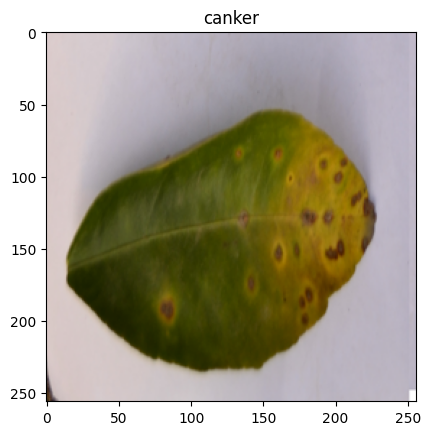

In [66]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

#Resize

In [67]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)])

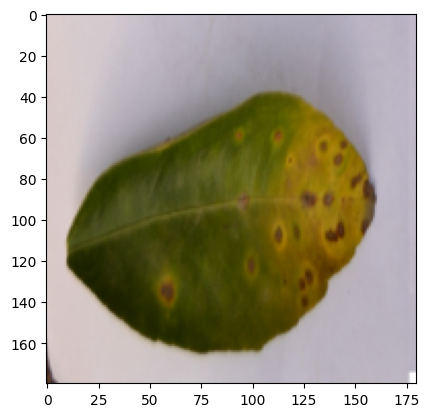

In [68]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [69]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


# Data Augmentation using Tensorflow layers

In [187]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [71]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [72]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds_noAug = prepare(test_ds)
test_ds_aug = prepare(test_ds, augment=True)


# Train model

In [73]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.3377 - loss: 3.0964 - val_accuracy: 0.2500 - val_loss: 1.2612
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.3156 - loss: 1.3061 - val_accuracy: 0.4000 - val_loss: 1.2287
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.3957 - loss: 1.2739 - val_accuracy: 0.5500 - val_loss: 1.1759
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.4615 - loss: 1.2139 - val_accuracy: 0.5333 - val_loss: 1.1170
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.4154 - loss: 1.1881 - val_accuracy: 0.4833 - val_loss: 1.0215


In [78]:
loss, acc = model.evaluate(test_ds_noAug)
print("Accuracy", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4726 - loss: 1.1032
Accuracy 0.47457626461982727


In [82]:
loss, acc = model.evaluate(test_ds_aug)
print("Accuracy", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4518 - loss: 1.0614 
Accuracy 0.47457626461982727


In summary, the similar accuracy suggests that the model is robust and that the augmentations didn’t distort the images enough to mislead the classifier.it means the model can handle natural variations well.

# Augmentation using GAN

In [188]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [189]:
(train_dsgan, val_dsgan, test_dsgan), metadata = tfds.load(
    'citrus_leaves',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [190]:
img_height = 56
img_width = 56
BATCH_SIZE = 32
BUFFER_SIZE = 6000
noise_dim = 100


In [191]:
def preprocess_image(image, label):
    # Resize image to the chosen dimensions.
    image = tf.image.resize(image, [img_height, img_width])
    # Convert image to float32 and normalize from [0, 255] to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

train_ds = train_dsgan.map(preprocess_image).shuffle(BUFFER_SIZE).batch(batch_size)

In [192]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Project and reshape: adjust the dense layer to produce a feature map for 7x7
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))  # Now shape is (7,7,256)

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 56x56
    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [193]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Set input_shape to (56, 56, 3)
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                            input_shape=[img_height, img_width, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [194]:
generator = make_generator_model()
discriminator = make_discriminator_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


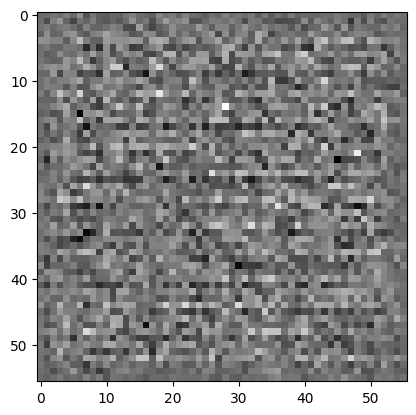

In [195]:

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [197]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0008273]], shape=(1, 1), dtype=float32)


In [198]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [199]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [200]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [201]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [202]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [219]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

#  will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [220]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [221]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [155]:
# generator = make_generator_model()
# discriminator = make_discriminator_model()
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [222]:
from IPython.display import display # Import the clear_output function
from IPython.display import clear_output
import time
import os
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as  go
    clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

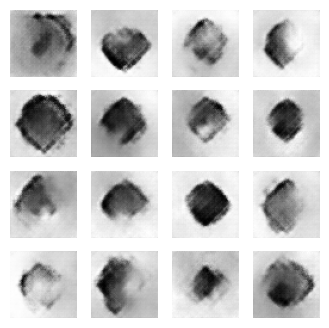

In [223]:
train(train_ds, EPOCHS )

In [208]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [224]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [225]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

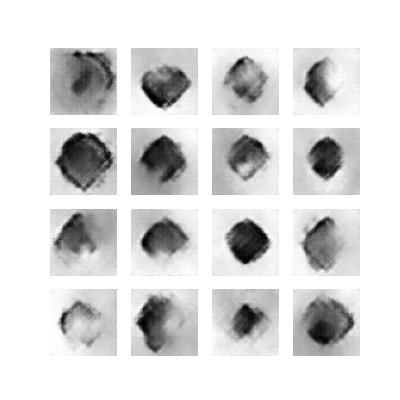

In [226]:
display_image(EPOCHS)

In [227]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-227-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-227-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



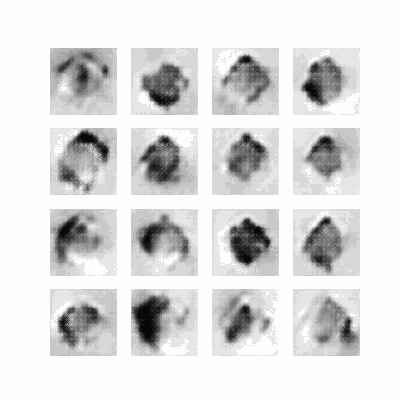

In [228]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [300]:
import os
import shutil

# Define the destination folder
dest_folder = "generated_images"

# Create the destination folder if it doesn't exist
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)

# List all files in the current directory
for filename in os.listdir("."):
    # Check if the filename matches the expected pattern
    if filename.startswith("image_at_epoch_") and filename.endswith(".png"):
        source_path = os.path.join(".", filename)
        dest_path = os.path.join(dest_folder, filename)
        shutil.move(source_path, dest_path)
        print(f"Moved {filename} to {dest_folder}")

# Adding images to training dataset

Found 173 files.
Number of batches in augmented_train_ds: -2
Batch images shape: (32, 180, 180, 3)
Batch labels shape: (32, 1)


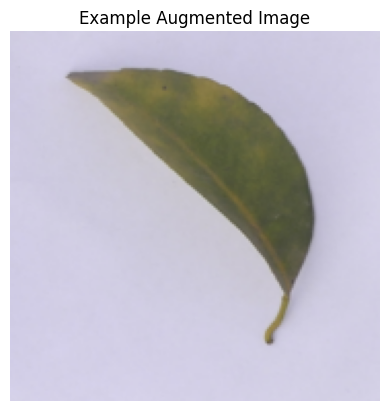

In [308]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

# === Configuration ===
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32

# === 1. Load the Original Dataset from tfds ===
(train_ds_orig, val_ds_orig, test_ds_orig), ds_info = tfds.load(
    'citrus_leaves',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

# Preprocessing function: resize and normalize to [-1,1]
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image, label

train_ds_orig = train_ds_orig.map(preprocess_image)
val_ds_orig   = val_ds_orig.map(preprocess_image)
test_ds_orig  = test_ds_orig.map(preprocess_image)

# --- Wrap labels so they are no longer scalars ---
def wrap_label(image, label):
    # Expand dims so that label shape becomes (1,) instead of scalar.
    label = tf.expand_dims(label, axis=-1)
    return image, label

train_ds_orig = train_ds_orig.map(wrap_label)
val_ds_orig   = val_ds_orig.map(wrap_label)
test_ds_orig  = test_ds_orig.map(wrap_label)

# Batch original datasets (if not already batched)
train_ds_orig = train_ds_orig.batch(BATCH_SIZE)
val_ds_orig = val_ds_orig.batch(BATCH_SIZE)
test_ds_orig = test_ds_orig.batch(BATCH_SIZE)

# === 2. Load the Generated Images Dataset ===
# Assume generated images are in a folder "generated_images" in the current directory.
generated_images_dir = pathlib.Path("generated_images")

generated_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=str(generated_images_dir),
    labels=None,             # No labels in the folder
    color_mode='grayscale',  # Generated images are grayscale
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Assign a default label (for instance, label 0) to the generated images.
generated_ds = generated_ds.map(lambda x: (x, tf.zeros(tf.shape(x)[0], dtype=tf.int64)))

# Since the original data is RGB, convert grayscale generated images to RGB.
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

generated_ds = generated_ds.map(convert_to_rgb)

# Normalize generated images to [-1,1]
def normalize_generated(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image, label

generated_ds = generated_ds.map(normalize_generated)

# Wrap labels for generated dataset as well
generated_ds = generated_ds.map(wrap_label)


train_ds_unbatched = train_ds_orig.unbatch()
generated_ds_unbatched = generated_ds.unbatch()

# Concatenate the unbatched datasets.
combined_ds = train_ds_unbatched.concatenate(generated_ds_unbatched)

# Shuffle and re-batch the combined dataset.
augmented_train_ds = combined_ds.shuffle(1000, seed=42).batch(BATCH_SIZE)

combined_card = augmented_train_ds.cardinality().numpy()  # number of batches
print("Number of batches in augmented_train_ds:", combined_card)


# === 5. Verify by Displaying a Batch ===
for images, labels in augmented_train_ds.take(1):
    print("Batch images shape:", images.shape)  # Expect: (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)
    print("Batch labels shape:", labels.shape)    # Expect: (BATCH_SIZE, 1)
    # Display the first image in the batch (rescale from [-1,1] to [0,255])
    plt.imshow(((images[0] + 1) * 127.5).numpy().astype("uint8"))
    plt.title("Example Augmented Image")
    plt.axis("off")
    plt.show()

In [312]:
import tensorflow as tf

# Assume ds_info is already defined from tfds.load, and holds label info.
num_classes = ds_info.features['label'].num_classes
print("Number of classes:", num_classes)

# Build a simple CNN classifier.
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Compile the model.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Labels are provided as integers.
    metrics=['accuracy']
)

# Set number of training epochs.
EPOCHS = 10

# Train the model using augmented_train_ds for training and val_ds_orig for validation.
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds_orig,  # Make sure validation set is batched.
    epochs=EPOCHS
)

# Optionally, evaluate on the test set.
test_loss, test_accuracy = model.evaluate(test_ds_orig)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Number of classes: 4


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,023,748 (30.61 MB)

 Trainable params: 8,023,748 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.4760 - loss: 1.2573 - val_accuracy: 0.7667 - val_loss: 0.6647
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8118 - loss: 0.4618 - val_accuracy: 0.7500 - val_loss: 0.5226
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8690 - loss: 0.3204 - val_accuracy: 0.8167 - val_loss: 0.4447
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9186 - loss: 0.2005 - val_accuracy: 0.8667 - val_loss: 0.3370
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9441 - loss: 0.1451 - val_accuracy: 0.8167 - val_loss: 0.5668
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8908 - loss: 0.2478 - val_accuracy: 0.8833 - val_loss: 0.2301
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9530 - loss: 0.1150 - val_accuracy: 0.9000 - val_loss: 0.1851
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9947 - loss: 0.0264 - val_accuracy: 0.8500 - 